In [26]:
import numpy as np
from rdkit import Chem
import deepchem as dc
import pandas as pd

In [2]:
data = pd.read_csv('../data/TASK1 Material_Drug_SMILES.csv')

In [3]:
data.head()

,drugbank_id,drug_name,type,SMILES
0,DB00006,Bivalirudin,small molecule,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...
1,DB00007,Leuprolide,small molecule,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...
2,DB00014,Goserelin,small molecule,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...
3,DB00027,Gramicidin D,small molecule,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...
4,DB00035,Desmopressin,small molecule,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...


In [4]:
mol_list = []
for smiles in data["SMILES"]:
    mol = Chem.MolFromSmiles(smiles)
    mol_list.append(mol)

[18:45:22] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[18:45:22] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[18:45:22] SMILES Parse Error: Failed parsing SMILES 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]' for input: 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]'
[18:45:22] Explicit valence for atom # 19 O, 3, is greater than permitted
[18:45:22] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:45:22] Unusual charge on atom 0 number of radical electrons set to zero
[18:45:22] Explicit valence for atom # 4 F, 2, is greater than permitted
[

In [27]:
featurizer = dc.feat.CircularFingerprint()
np.sum(featurizer.featurize(data["SMILES"][0])[0])

[10:58:22] DEPRECATION WARNING: please use MorganGenerator


np.float64(107.0)

In [31]:
from rdkit.Chem.Descriptors import descList
rdkit_featurizer = dc.feat.RDKitDescriptors()
features = rdkit_featurizer(data["SMILES"][0])[0]
descriptors = [i[0] for i in descList]
for feature, descriptor in zip(features[:20], descriptors):
    print(descriptor, feature)

MaxAbsEStateIndex 1.7118194486284366
MaxEStateIndex 2.458859412288004
MinAbsEStateIndex -2.3287219318795533
MinEStateIndex 2.26656321929664
qed -2.61159586104492
SPS 6.028496919505985
MolWt -0.1440184612183397
HeavyAtomMolWt 16.387121549434386
ExactMolWt 9.96055219259474
NumValenceElectrons 1.052628361033579
NumRadicalElectrons 5529.13104588967
MaxPartialCharge 114.9925909434234
MinPartialCharge 85.84391765747674
MaxAbsPartialCharge 85.84391765747674
MinAbsPartialCharge 73.30358292411128
FpDensityMorgan1 50.20107861427791
FpDensityMorgan2 50.20107861427791
FpDensityMorgan3 37.74108816394006
BCUT2D_MWHI 37.74108816394006
BCUT2D_MWLOW 25.145697845559017


In [32]:
from torch_geometric.nn import Node2Vec
import torch

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128, 
                 walk_length=20,                        # lenght of rw
                 context_size=10, walks_per_node=20,
                 num_negative_samples=1, 
                 p=200, q=1,                             # bias parameters
                 sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [ ]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [ ]:
@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

In [ ]:
for epoch in range(1, 201):
    loss = train()
    #acc = test()
    #print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

In [5]:
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
%matplotlib inline

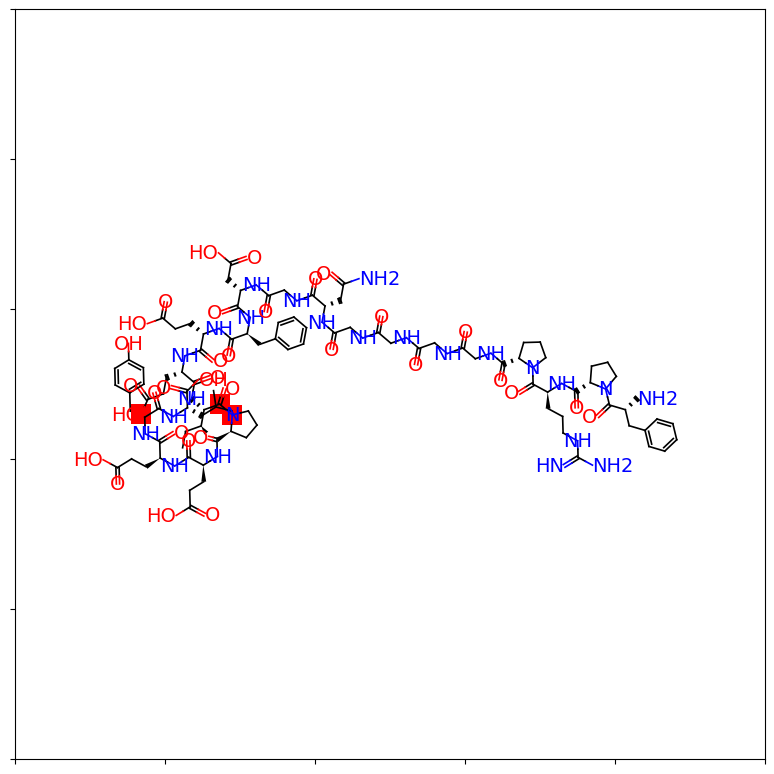

In [13]:
Draw.MolToMPL(mol_list[0], size=(300, 300))
plt.show()

In [33]:
import deepchem as dc

tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

[11:30:00] WARNING: not removing hydrogen atom without neighbors
[11:30:13] WARNING: not removing hydrogen atom without neighbors


In [41]:
train_dataset.X[0]

In [1]:
import deepchem as dc
import numpy as np
from deepchem.models.torch_models import GraphConvModel
featurizer = dc.feat.ConvMolFeaturizer()
tasks = ["outcome"]
mols = ["C", "CO", "CC"]
X = featurizer(mols)
y = np.array([0, 1, 0])
dataset = dc.data.NumpyDataset(X, y)
classification_metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification")
batch_size = 10
model = GraphConvModel(len(tasks), number_input_features=[75, 64], batch_size=batch_size, batch_normalize=False, mode='classification')
loss = model.fit(dataset, nb_epoch=20)

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torchdata.datapipes'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/roozbeh/Desktop/comp-bio/task1/.venv/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


ImportError: cannot import name 'GraphConvModel' from 'deepchem.models.torch_models' (/home/roozbeh/Desktop/comp-bio/task1/.venv/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)

In [3]:
import torchdata.datapipes as dp

ModuleNotFoundError: No module named 'torchdata.datapipes'

In [4]:
!pip install torchdata